In [71]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), 
              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a"), UUID("95e70727-a04e-3e33-b7fe-34ab19194f8b")]

In [72]:
list(edb.get_timeseries_db().find({"metadata.key": "config/sensor_config", "data.battery_status": {"$exists": True}}).sort("metadata.write_ts").limit(10))

[{u'_id': ObjectId('56fadecd88f66341cb3618c9'),
  u'data': {u'android_health': u'GOOD',
   u'android_plugged': u'USB',
   u'android_technology': u'Li-ion',
   u'android_temperature': 226,
   u'android_voltage': 226,
   u'battery_level_pct': 100,
   u'battery_status': 5},
  u'metadata': {u'key': u'config/sensor_config',
   u'platform': u'android',
   u'read_ts': 1459281599.629,
   u'time_zone': u'America/Los_Angeles',
   u'type': u'sensor-data',
   u'write_fmt_time': u'2016-03-29T11:56:24.694000-07:00',
   u'write_local_dt': datetime.datetime(2016, 3, 29, 11, 56, 24, 694000),
   u'write_ts': 1459277784.694},
  u'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')},
 {u'_id': ObjectId('56faecf288f66323bcc68ee9'),
  u'data': {u'android_health': u'GOOD',
   u'android_plugged': u'USB',
   u'android_technology': u'Li-ion',
   u'android_temperature': 197,
   u'android_voltage': 197,
   u'battery_level_pct': 100,
   u'battery_status': 2},
  u'metadata': {u'key': u'config/sensor_config',
   

In [73]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

#time query specification
#iOS: video playback
dt1 = pydt.datetime(2016, 8, 3, 16, 0) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 8, 3, 23, 0)

ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))

time_rangei = estt.TimeQuery("metadata.write_ts", ts1, ts2)


#BuiltinTimeSeries.get_data_df(key, time_query = None, geo_query = None, extra_query_list=None) 
#type: list of DataFrame objects (regarding state info)
iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)

In [74]:
iphone_test = iphone_battery_df_list[1]
iphone_test[['fmt_time', 'battery_level_pct', 'battery_status']]

KeyError: "['fmt_time' 'battery_level_pct' 'battery_status'] not in index"

In [58]:
def get_ranges_df(battery_df, state_df):
    #the experiment runs until the battery drains completely
    #so start_ts should be the last time it was reported 100% battery level
    full_df = battery_df[battery_df.battery_level_pct == 100]
    last_full_ts = full_df.iloc[-1].ts 
    
    start_ts = last_full_ts
    end_ts = battery_df.iloc[-1].ts
    
    #find start_ts & end_ts for the period when battery_status=1=discharging
    #discharging_df = battery_df[battery_df.battery_status == 1]
    #discharging_df.reset_index(inplace=True)
    #start_ts = discharging_df.iloc[0].ts
    #end_ts = discharging_df.iloc[-1].ts
    
    ranges_df = pd.DataFrame({'start_ts': [start_ts], 'end_ts': [end_ts]})
    return ranges_df

In [59]:
def get_ranges_df_list(battery_df_list, state_df_list):
    ranges_df_list = []
    length = len(battery_df_list)
    for i in range(0, length):
        ranges_df_list.append(get_ranges_df(battery_df_list[i], state_df_list[i]))
    return ranges_df_list

In [60]:
iphone_ranges_df_list = get_ranges_df_list(iphone_battery_df_list, iphone_state_df_list)

#iphone_concat_ranges_df = pd.concat([iphone_ranges_df_list[0], iphone_ranges_df_list[1], iphone_ranges_df_list[2], iphone_ranges_df_list[3]])
#print iphone_concat_ranges_df

iphone_ranges_df = pd.DataFrame()
for df in iphone_ranges_df_list:
    iphone_ranges_df = iphone_ranges_df.append(df)

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
iphone_ranges_df['start_dt'] = iphone_ranges_df.start_ts.apply(ts_to_dt)
iphone_ranges_df['end_dt'] = iphone_ranges_df.end_ts.apply(ts_to_dt)

iphone_ranges_df

AttributeError: 'DataFrame' object has no attribute 'battery_level_pct'

In [61]:
iphone_start_ts = iphone_ranges_df.start_ts.max() 
iphone_end_ts = iphone_ranges_df.end_ts.min() + 60*60
i_t1 = pydt.datetime.fromtimestamp(iphone_start_ts)
i_t2 = pydt.datetime.fromtimestamp(iphone_end_ts)
print 'iphone_start_ts=' + str(i_t1) + '\n' + 'iphone_end_ts=' + str(i_t2)
print  (iphone_end_ts-iphone_start_ts)/3600.0


iphone_start_ts=2016-07-21 15:10:06.557952
iphone_end_ts=2016-07-22 01:00:11.477409
9.83469984916


In [62]:
import numpy as np

iphone_xnew = np.arange(iphone_start_ts, iphone_end_ts, 15 * 60) # 15 minutes
print len(iphone_xnew)


40


In [63]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [64]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [65]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)


AttributeError: 'DataFrame' object has no attribute 'ts'

In [66]:
label = ['1hr', '1hr', '1hr', '1hr']
style = ['ob', 'og', 'or', 'oc']
title = "TrackingOn_Stationary_HAFS "

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

About to plot 0
About to plot 1


AttributeError: 'DataFrame' object has no attribute 'ts'

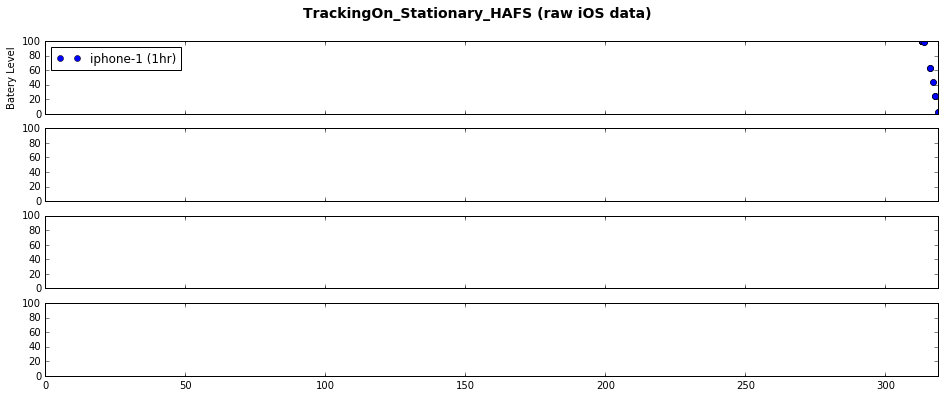

In [67]:
#iOS: No interplation on battery data
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle(title + '(raw iOS data)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=aaxes[i], label="iphone-%s (1hr)" % (i+1))
    aaxes[i].set_xlabel('Hours')
    aaxes[i].set_ylabel('Batery Level')
    aaxes[i].set_xlim(left=0)
    #plt.xticks(np.arange(0, max(df['hr'])+2, 2.0))
    
#afig.savefig('scatter_Apr_2-3_iOS.png')

In [ ]:
#iOS: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle(title + '(iOS_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 7), label="iphone-%s (1hr)" % (i+1))
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, max(df['hr']), 2.0))

#ifig.savefig('interp_Apr_2-3_iOS.png') 

About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0
About to plot 1


KeyError: 'hr'

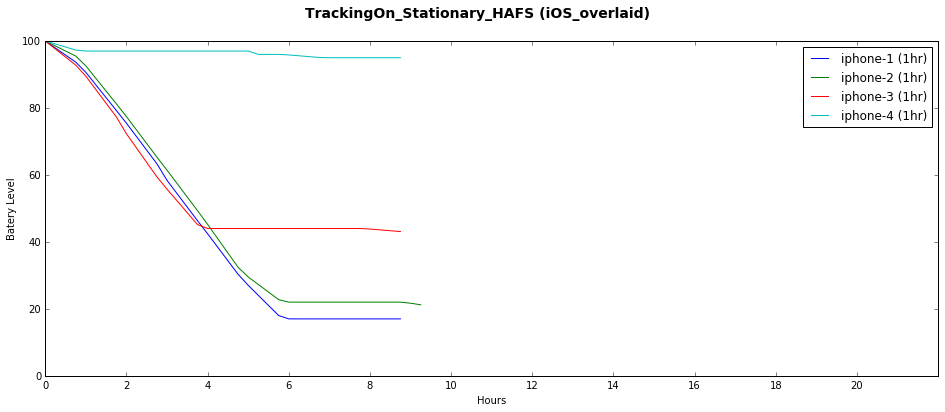

In [68]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle(title + '(iOS_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 22), label="iphone-%s (1hr)" % (i+1), legend=True)

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, xlim=(0, 22), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, 22, 2.0))

    
#ifig.savefig('overlaid_Apr_2-3_iOS.png')  

In [ ]:
#iOS
#correlation analysis 
#generate list of iphone battery series 
iphone_battery_series_list = map(lambda b: b.battery_level_pct, iphone_battery_interp_df_list)
print np.corrcoef(iphone_battery_series_list)
plt.matshow(np.corrcoef(iphone_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

4
About to plot 0
About to plot 1
About to plot 2
About to plot 3


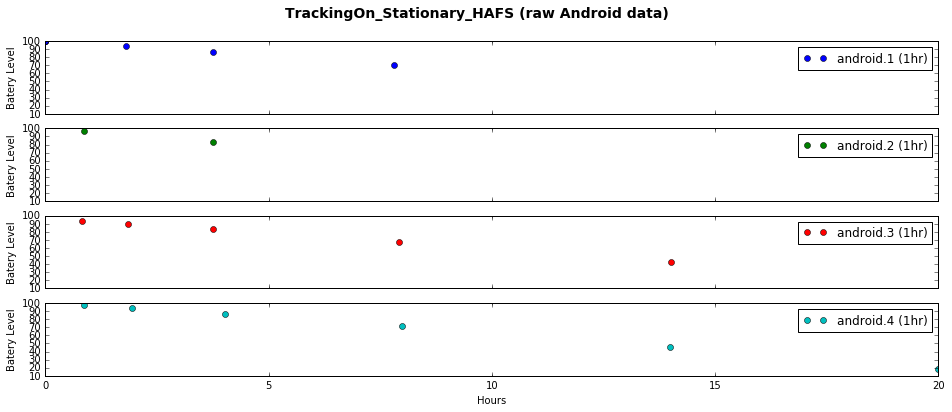

In [216]:
#Android: No interplation on battery data 
print len(android_battery_df_list)
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle(title + '(raw Android data)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=aaxes[i], label="android.%s (1hr)" % (i+1))
    aaxes[i].set_xlabel('Hours')
    aaxes[i].set_ylabel('Batery Level')
    aaxes[i].set_xlim(left=0)
    #plt.xticks(np.arange(0, max(df['hr'])+2, 1))
    
#afig.savefig('scatter_Apr_2-3_Android.png')

About to plot 0
About to plot 1
About to plot 2
About to plot 3


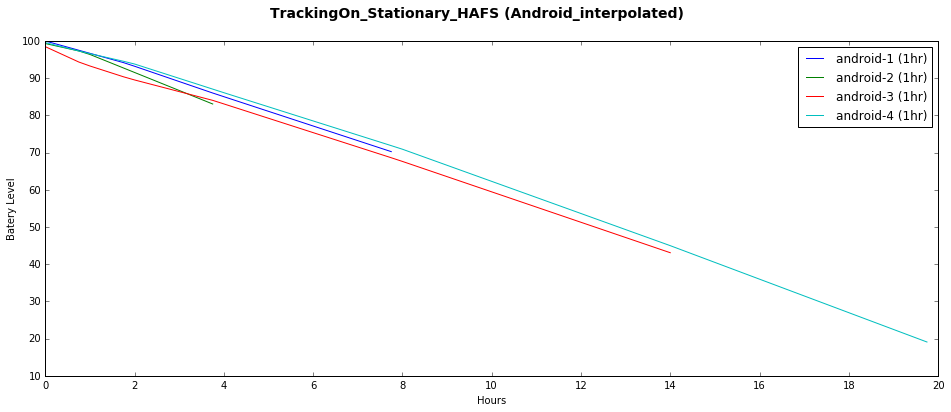

In [217]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle(title + '(Android_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 20), label="android-%s (1hr)" % (i+1))
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, 22, 2))
    
#ifig.savefig('interp_Apr_2-3_Android.png')    

About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0
About to plot 1
About to plot 2
About to plot 3


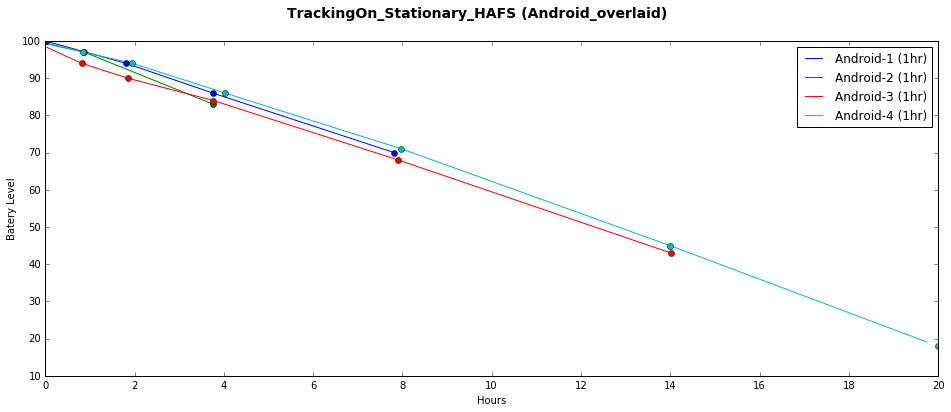

In [218]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle(title + '(Android_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, max(df.hr)), label="Android-%s (1hr)" % (i+1), legend=True)


for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, xlim=(0, max(df.hr)), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, max(df['hr'])+1, 2))
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
    
#ifig.savefig('overlaid_Apr_2-3_Android.png') 

[[ 1.                 nan  0.99225982  0.99961347]
 [        nan         nan         nan         nan]
 [ 0.99225982         nan  1.          0.98960398]
 [ 0.99961347         nan  0.98960398  1.        ]]


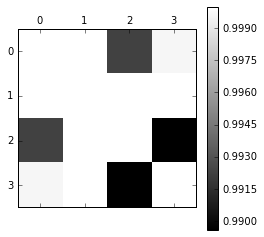

In [137]:
#Android 
#correlation analysis(tracking_off+stationary)
#generate list of android battery series 
android_battery_series_list = map(lambda b: b.battery_level_pct, android_battery_interp_df_list)
print np.corrcoef(android_battery_series_list)
plt.matshow(np.corrcoef(android_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

In [50]:
l = [1,2]
len(l)

2

In [25]:
l.append(3)
l
len(l)

3